In [9]:
# ======================================================
# Which temporal factors predict higher emergency incident volume
# in Austin, and how do seasonal patterns relate to incident risk?
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

# ------------------------------------------------------
# 1. LOAD & CLEAN INCIDENT-LEVEL DATA
# ------------------------------------------------------
fire = pd.read_csv("AFD_Fire_Incidents_2022-2024_20251201.csv")

# Ensure IncDate is datetime
fire['IncDate'] = pd.to_datetime(fire['IncDate'], errors='coerce')
fire = fire.dropna(subset=['IncDate']).copy()

# ------------------------------------------------------
# 2. DEFINE SEASON FUNCTION (AUSTIN METEOROLOGICAL SEASONS)
# ------------------------------------------------------
def get_season(month):
    """
    Map month (1-12) to meteorological season in Austin:
    - Spring: Mar–May (3, 4, 5)
    - Summer: Jun–Aug (6, 7, 8)
    - Fall:   Sep–Nov (9, 10, 11)
    - Winter: Dec–Feb (12, 1, 2)
    """
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

# ------------------------------------------------------
# 3. DAILY AGGREGATION + TEMPORAL FEATURES
# ------------------------------------------------------
# Daily incident counts
daily = fire.groupby(fire['IncDate'].dt.date).size().reset_index(name='Count')
daily['IncDate'] = pd.to_datetime(daily['IncDate'])

# Basic temporal features
daily['Month'] = daily['IncDate'].dt.month
daily['DayOfWeek'] = daily['IncDate'].dt.dayofweek    # 0=Mon, 6=Sun
daily['IsWeekend'] = (daily['DayOfWeek'] >= 5).astype(int)
daily['Year'] = daily['IncDate'].dt.year

# Holiday list (you can add more if needed)
holiday_dates = pd.to_datetime([
    # New Year's Day
    "2022-01-01", "2023-01-01", "2024-01-01",
    # New Year's Eve
    "2022-12-31", "2023-12-31", "2024-12-31",
    # Christmas Eve
    "2022-12-24", "2023-12-24", "2024-12-24",
    # Christmas Day
    "2022-12-25", "2023-12-25", "2024-12-25",
    # Valentine's Day
    "2022-02-14", "2023-02-14", "2024-02-14",
    # July 4th
    "2022-07-04", "2023-07-04", "2024-07-04",
    # Thanksgiving (approx for each year)
    "2022-11-24", "2023-11-23", "2024-11-28"
])

daily['Holiday'] = daily['IncDate'].isin(holiday_dates).astype(int)

# Season feature
daily['Season'] = daily['Month'].apply(get_season)

# ------------------------------------------------------
# 4. LAG FEATURES & MOVING AVERAGES (DAILY)
# ------------------------------------------------------
daily = daily.sort_values('IncDate')

# Lagged counts (yesterday, last week)
daily['Count_lag1'] = daily['Count'].shift(1)
daily['Count_lag7'] = daily['Count'].shift(7)

# 7-day moving average
daily['Count_MA7'] = daily['Count'].rolling(window=7, min_periods=1).mean()

# Drop rows with NaNs in lag features for modeling
daily_model = daily.dropna(subset=['Count_lag1', 'Count_lag7']).copy()

# ------------------------------------------------------
# 5. WEEKLY AGGREGATION + FEATURES
# ------------------------------------------------------
weekly = daily.set_index('IncDate').resample('W').agg({
    'Count': 'sum',
    'Holiday': 'max'  # if any holiday in the week, mark as 1
}).reset_index()

weekly['Year'] = weekly['IncDate'].dt.year
weekly['WeekOfYear'] = weekly['IncDate'].dt.isocalendar().week.astype(int)
weekly['Month'] = weekly['IncDate'].dt.month
weekly['Season'] = weekly['Month'].apply(get_season)

# Lags + moving average at weekly level
weekly = weekly.sort_values('IncDate')
weekly['Count_lag1'] = weekly['Count'].shift(1)   # previous week
weekly['Count_lag4'] = weekly['Count'].shift(4)   # ~one month ago
weekly['Count_MA4'] = weekly['Count'].rolling(window=4, min_periods=1).mean()

weekly_model = weekly.dropna(subset=['Count_lag1', 'Count_lag4']).copy()

/var/folders/zw/dq9jsr591qsgk83k74qd48w40000gn/T/ipykernel_1743/2555133227.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fire['IncDate'] = pd.to_datetime(fire['IncDate'], errors='coerce')


In [10]:
# ------------------------------------------------------
# 6. DAILY RANDOM FOREST REGRESSION MODEL
# ------------------------------------------------------
daily_features = [
    'DayOfWeek', 'IsWeekend', 'Month', 'Year',
    'Holiday', 'Season',
    'Count_lag1', 'Count_lag7', 'Count_MA7'
]
daily_target = 'Count'

X_daily = daily_model[daily_features]
y_daily = daily_model[daily_target]

daily_cat = ['Season']
daily_num = [f for f in daily_features if f not in daily_cat]

daily_preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), daily_cat),
        ('num', 'passthrough', daily_num)
    ]
)

daily_rf = Pipeline(steps=[
    ('preprocess', daily_preprocess),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(
    X_daily, y_daily, test_size=0.2, random_state=42
)

daily_rf.fit(Xtr_d, ytr_d)
y_pred_d = daily_rf.predict(Xte_d)
r2_daily = r2_score(yte_d, y_pred_d)
print("Daily model R²:", r2_daily)

Daily model R²: 0.26107734760119483


In [11]:
# ------------------------------------------------------
# 7. WEEKLY RANDOM FOREST REGRESSION MODEL
# ------------------------------------------------------
weekly_features = [
    'WeekOfYear', 'Year', 'Month',
    'Holiday', 'Season',
    'Count_lag1', 'Count_lag4', 'Count_MA4'
]
weekly_target = 'Count'

X_week = weekly_model[weekly_features]
y_week = weekly_model[weekly_target]

weekly_cat = ['Season']
weekly_num = [f for f in weekly_features if f not in weekly_cat]

weekly_preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), weekly_cat),
        ('num', 'passthrough', weekly_num)
    ]
)

weekly_rf = Pipeline(steps=[
    ('preprocess', weekly_preprocess),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

Xtr_w, Xte_w, ytr_w, yte_w = train_test_split(
    X_week, y_week, test_size=0.2, random_state=42
)

weekly_rf.fit(Xtr_w, ytr_w)
y_pred_w = weekly_rf.predict(Xte_w)
r2_weekly = r2_score(yte_w, y_pred_w)
print("Weekly model R²:", r2_weekly)

Weekly model R²: 0.23072108760920906


In [27]:
# ------------------------------------------------------
# 8. INCIDENT-LEVEL FEATURES + STRUCTURE FIRE TARGET
# ------------------------------------------------------
fire['Month'] = fire['IncDate'].dt.month
fire['DayOfWeek'] = fire['IncDate'].dt.dayofweek
fire['Season'] = fire['Month'].apply(get_season)

# Structure fires based on Problem text
if 'Problem' in fire.columns:
    fire['IsStructureFire'] = fire['Problem'].str.contains(
        'STRUCTURE', case=False, na=False
    ).astype(int)
else:
    fire['IsStructureFire'] = 0

print("\nIsStructureFire value counts:")
print(fire['IsStructureFire'].value_counts(dropna=False))
print("1 is incident is a structure fire, 0 isn't")


IsStructureFire value counts:
IsStructureFire
0    18904
1     2031
Name: count, dtype: int64
1 is incident is a structure fire, 0 isn't



Probability of Structure Fire by Season:
Season
Winter    0.093958
Fall      0.096293
Summer    0.097743
Spring    0.100999
Name: IsStructureFire, dtype: float64


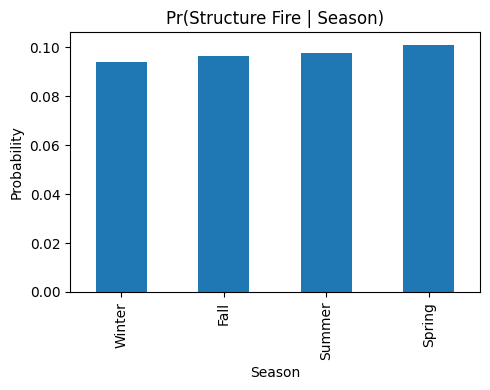

In [ ]:
# ------------------------------------------------------
# 9. SEASONAL RATES FOR STRUCTURE FIRES
# ------------------------------------------------------
season_struct = fire.groupby('Season')['IsStructureFire'].mean().sort_values()
print("\nProbability of Structure Fire by Season:")
print(season_struct)

fig, ax = plt.subplots(figsize=(5, 4))
season_struct.plot(kind='bar', ax=ax)
ax.set_title("Pr(Structure Fire | Season)")
ax.set_ylabel("Probability")
plt.tight_layout()
plt.show()


In [42]:
# ------------------------------------------------------
# 10. LOGISTIC REGRESSION: BINARY INCIDENT RISK - PREDICTIVE
# ------------------------------------------------------
# Choose which binary target you want to model:
# target_inc = 'IsStructureFire'   # recommended
# target_inc = 'IsLifeThreat'      # only if it has both 0 and 1
target_inc = 'IsStructureFire'

fire_model = fire.dropna(subset=[target_inc]).copy()

features_inc = ['Season', 'DayOfWeek', 'Month']
X_inc = fire_model[features_inc]
y_inc = fire_model[target_inc]

print(f"\nOverall {target_inc} classes:")
print(y_inc.value_counts())

# If there is only one class in the whole dataset, skip modeling
if y_inc.nunique() < 2:
    print(f"\n[LOGIT SKIPPED] Only one class present in {target_inc}. "
          "Cannot fit logistic regression.")
else:
    inc_cat = ['Season']
    inc_num = ['DayOfWeek', 'Month']

    inc_preprocess = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), inc_cat),
            ('num', 'passthrough', inc_num)
        ]
    )

    logit = Pipeline(steps=[
        ('preprocess', inc_preprocess),
        ('model', LogisticRegression(max_iter=1000))
    ])

    Xtr_i, Xte_i, ytr_i, yte_i = train_test_split(
        X_inc, y_inc, test_size=0.2, random_state=42
    )

    # Extra guard: make sure the TRAIN SPLIT has two classes
    print(f"\nTrain split {target_inc} classes:")
    print(ytr_i.value_counts())

    if ytr_i.nunique() < 2:
        print("\n[LOGIT SKIPPED] Train split ended up with only one class "
              "(try a different random_state, smaller test_size, or note this as a limitation).")
    else:
        logit.fit(Xtr_i, ytr_i)
        logit_acc = logit.score(Xte_i, yte_i)
        print(f"\nLogistic regression accuracy ({target_inc} vs not):", logit_acc)



Overall IsStructureFire classes:
IsStructureFire
0    18904
1     2031
Name: count, dtype: int64

Train split IsStructureFire classes:
IsStructureFire
0    15092
1     1656
Name: count, dtype: int64

Logistic regression accuracy (IsStructureFire vs not): 0.9104370671124911


/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/utils/e

In [43]:
# ======================================================
# Seasonal Probability Graphs for ALL incident categories
# ======================================================
# ======================================================
# Map cryptic CAD/dispatch codes into human-readable categories
# ======================================================

def map_incident_group(problem):
    """
    Maps AFD dispatch codes (e.g., BOXHI, COXMAR, BRSHL) into broad,
    human-readable fire incident categories for interpretation.
    """
    p = str(problem).upper()
    
    # Structure fires
    if 'STRUCTURE' in p or 'BLDG' in p or 'HOUSE' in p:
        return 'Structure Fire'
    
    # Brush / Grass fires
    if 'BRSH' in p or 'BRUSH' in p or 'GRASS' in p or 'WILD' in p:
        return 'Brush / Grass Fire'
    
    # Box alarms / fire alarms (all the BOXxx codes)
    if p.startswith('BOX'):
        return 'Box Alarm / Fire Alarm'
    
    # CO detectors / gas alarms
    if 'CO' in p or 'CARBON MONOXIDE' in p or 'COX' in p:
        return 'CO / Gas Alarm'
    
    # Vehicle fires
    if 'VEH' in p or 'CAR FIRE' in p or 'AUTO FIRE' in p or 'TRUCK' in p:
        return 'Vehicle Fire'
    
    # Trash / dumpster / debris fires
    if 'TRASH' in p or 'DUMP' in p or 'DUMPSTER' in p or 'DEBRIS' in p:
        return 'Trash / Dumpster Fire'
    
    # Medical/EMS
    if 'MED' in p or 'EMS' in p or 'MEDICAL' in p:
        return 'Medical / EMS'
    
    # Hazmat
    if 'HAZ' in p or 'HAZMAT' in p:
        return 'Hazmat'
    
    # Rescue / technical rescues
    if 'RESCUE' in p or 'TECH' in p:
        return 'Rescue / Technical'
    
    # Water-related calls
    if 'WATER' in p or 'DROWN' in p or 'FLOOD' in p:
        return 'Water / Flood'
    
    # Default catch-all
    return 'Other'


# Apply mapping
fire['IncidentGroup'] = fire['Problem'].apply(map_incident_group)


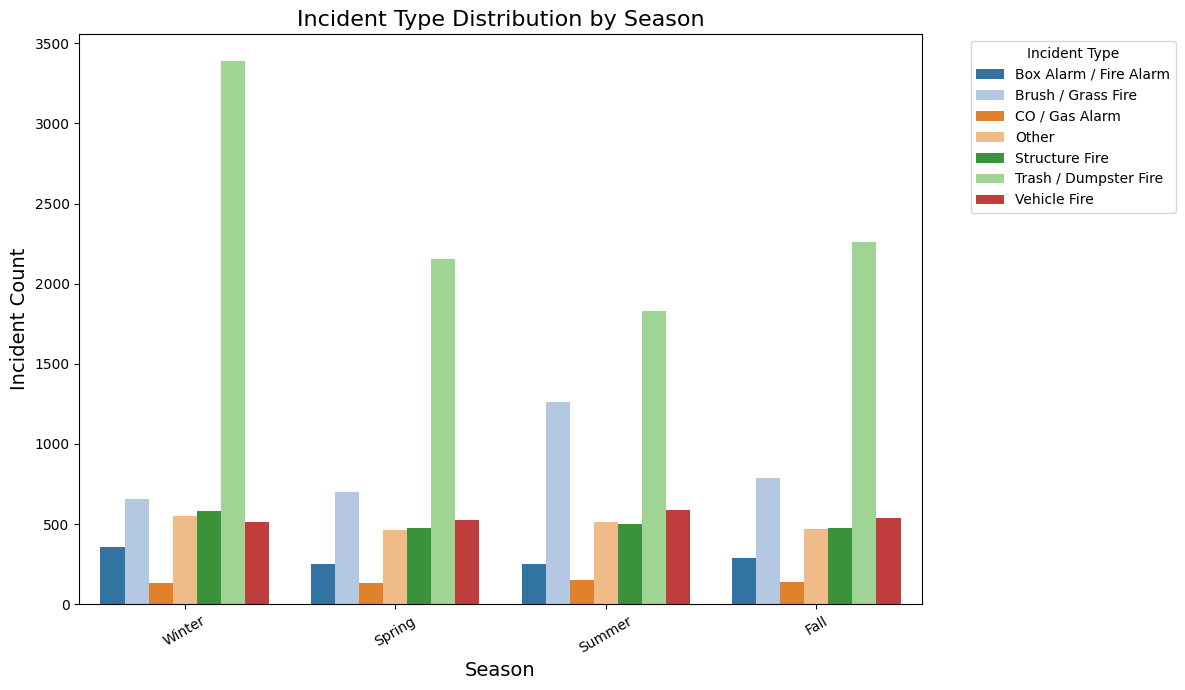

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Season order is consistent
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Count incidents per season per group
season_counts = (
    fire.groupby(['Season', 'IncidentGroup'])
        .size()
        .reset_index(name='Count')
)

# Sort seasons properly
season_counts['Season'] = pd.Categorical(
    season_counts['Season'],
    categories=season_order,
    ordered=True
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=season_counts,
    x='Season',
    y='Count',
    hue='IncidentGroup',
    palette='tab20'
)
plt.title("Incident Type Distribution by Season", fontsize=16)
plt.xticks(rotation=30)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Incident Count", fontsize=14)
plt.legend(title="Incident Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


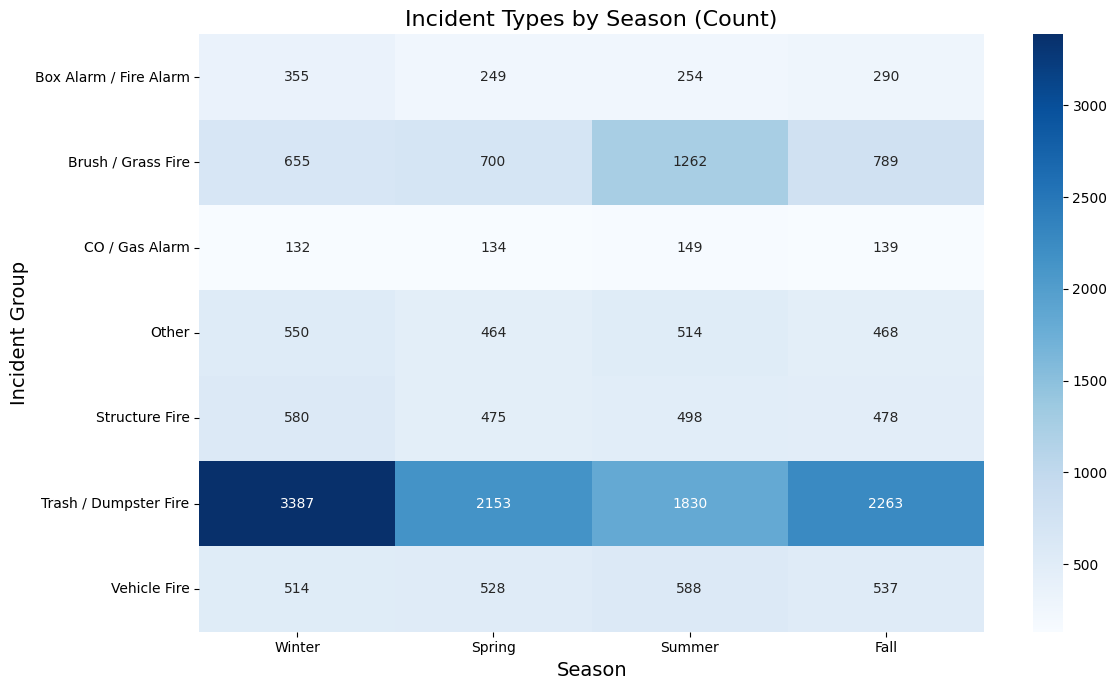

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Season exists
fire['Month'] = fire['IncDate'].dt.month
fire['Season'] = fire['Month'].apply(get_season)

# Set consistent season order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Create pivot table
heat = fire.pivot_table(
    index='IncidentGroup',        # FIXED
    columns='Season',
    values='Problem',
    aggfunc='count'
).reindex(columns=season_order).fillna(0)

plt.figure(figsize=(12, 7))
sns.heatmap(heat, annot=True, fmt=".0f", cmap="Blues")
plt.title("Incident Types by Season (Count)", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Incident Group", fontsize=14)
plt.tight_layout()
plt.show()



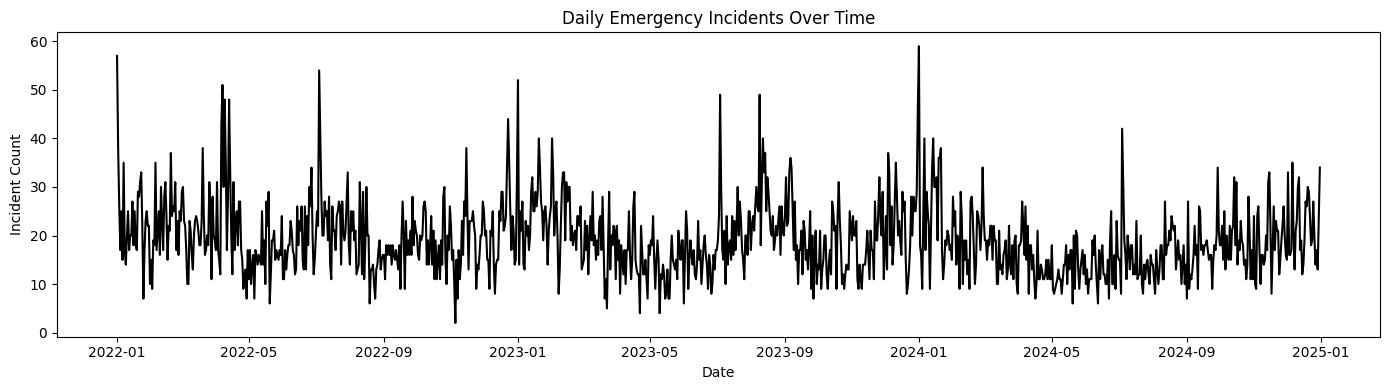

/var/folders/zw/dq9jsr591qsgk83k74qd48w40000gn/T/ipykernel_1743/3022857756.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily, x='Holiday', y='Count', palette=['gray','red'])


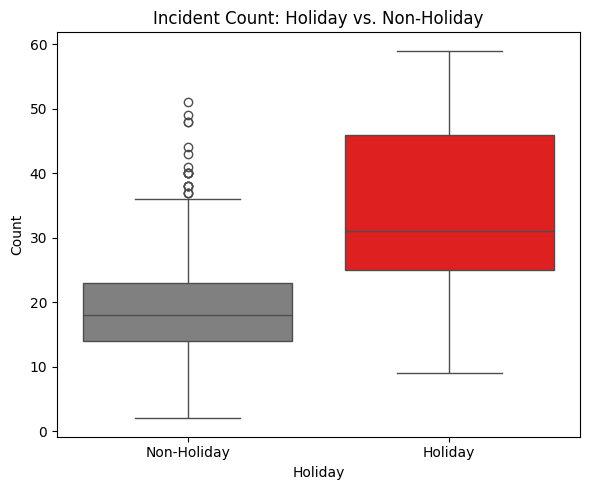

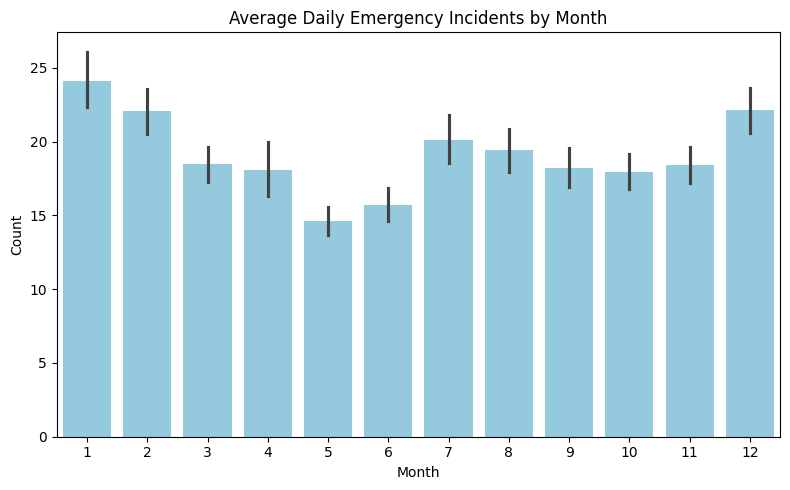

In [46]:
# ======================================================
# USE UPDATED DAILY MODELING FRAMEWORK
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

daily_model = daily.dropna(subset=['Count_lag1','Count_lag7','Count_MA7']).copy()

features = [
    'Month','DayOfWeek','IsWeekend','Holiday','Season',
    'Count_lag1','Count_lag7','Count_MA7'
]

target = 'Count'

X = daily_model[features]
y = daily_model[target]

# ------------------------------------------------------
# 2. PREPROCESSOR
# ------------------------------------------------------
cat_cols = ['Season']
num_cols = [c for c in features if c not in cat_cols]

pre = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ======================================================
# 3. VISUALS BASE - NOT FOR MODELS
# ======================================================

# VISUAL 1 — Daily Trend
plt.figure(figsize=(14,4))
plt.plot(daily['IncDate'], daily['Count'], color='black')
plt.title("Daily Emergency Incidents Over Time")
plt.xlabel("Date")
plt.ylabel("Incident Count")
plt.tight_layout()
plt.show()

# VISUAL 2 — Holiday vs Non-Holiday
plt.figure(figsize=(6,5))
sns.boxplot(data=daily, x='Holiday', y='Count', palette=['gray','red'])
plt.xticks([0,1], ["Non-Holiday","Holiday"])
plt.title("Incident Count: Holiday vs. Non-Holiday")
plt.tight_layout()
plt.show()

# VISUAL 3 — Monthly Average
plt.figure(figsize=(8,5))
sns.barplot(data=daily, x='Month', y='Count', estimator='mean', color='skyblue')
plt.title("Average Daily Emergency Incidents by Month")
plt.tight_layout()
plt.show()




/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


Linear Regression R²: 0.39241446285950554
Random Forest R²: 0.27423933543153667


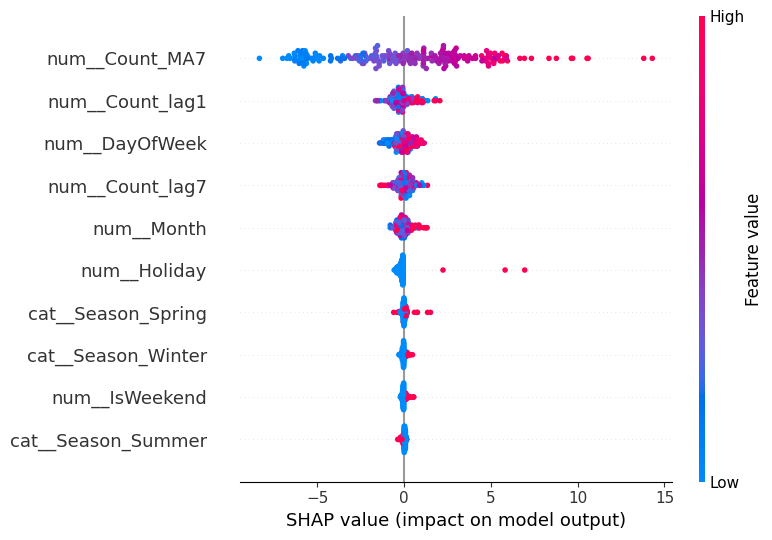

CatBoost R²: 0.31587821762200163


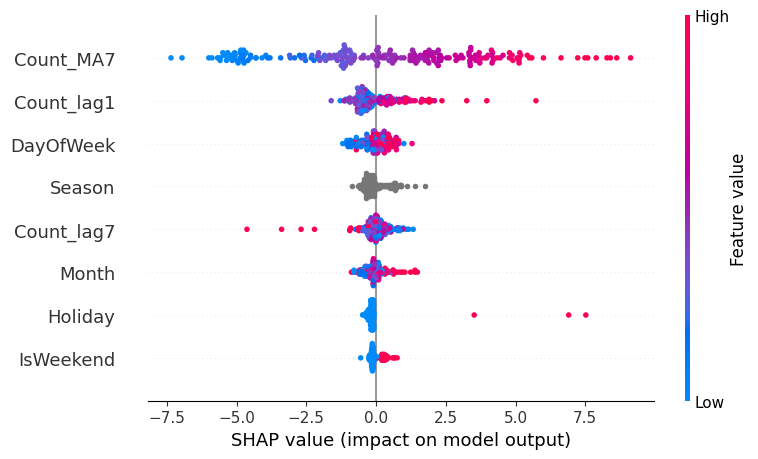

Elastic Net R²: 0.38096404958176466


/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/annikagodines/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [47]:
# ======================================================
# 4. MODELS
# ======================================================

# -----------------------------
# Linear Regression
# -----------------------------
model_lr = Pipeline([
    ('pre', pre),
    ('lr', LinearRegression())
])

model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, pred_lr))


# -----------------------------
# Random Forest
# -----------------------------
model_rf = Pipeline([
    ('pre', pre),
    ('rf', RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2
    ))
])

model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, pred_rf))

# SHAP (Random Forest)
X_pre = model_rf.named_steps['pre'].transform(X_test).astype(float)
explainer_rf = shap.TreeExplainer(model_rf.named_steps['rf'])
shap_values_rf = explainer_rf.shap_values(X_pre)

shap.summary_plot(
    shap_values_rf,
    X_pre,
    feature_names=model_rf.named_steps['pre'].get_feature_names_out()
)


# -----------------------------
# CatBoost (best for tabular)
# -----------------------------
cat_features_idx = [0]  # ONLY Season is categorical AFTER preprocessing is removed

# For CatBoost we feed raw X (no OneHot)
model_cat = CatBoostRegressor(
    depth=6,
    learning_rate=0.05,
    n_estimators=400,
    loss_function='RMSE',
    verbose=False,
    random_state=42
)

model_cat.fit(
    X_train,
    y_train,
    cat_features=['Season']  # CatBoost handles this automatically
)

pred_cat = model_cat.predict(X_test)

print("CatBoost R²:", r2_score(y_test, pred_cat))

# SHAP for CatBoost
explainer_cat = shap.TreeExplainer(model_cat)
shap_values_cat = explainer_cat.shap_values(X_test)

shap.summary_plot(
    shap_values_cat,
    X_test,
    feature_names=X.columns
)


# -----------------------------
# ElasticNet Regression
# -----------------------------
model_en = Pipeline([
    ('pre', pre),
    ('en', ElasticNet(alpha=0.05, l1_ratio=0.3))
])

model_en.fit(X_train, y_train)
pred_en = model_en.predict(X_test)

print("Elastic Net R²:", r2_score(y_test, pred_en))